<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/preprocessing/voice-analysis.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/preprocessing/voice-analysis.ipynb)

# Analyzing Vocal Features for Pathology

This notebook goes through a simple voice analysis of a few speech samples. If you are new to speech feature extraction, we recommend reading through [Aalto Speech Processing Ch. 3 Basic Representations](https://speechprocessingbook.aalto.fi/Representations/Representations.html)  before going through the notebook to understand the background and theory behind the signal processing techniques used here. Throughout the tutorial, there are several mentions of the PRAAT software, which is an early open-source software used to compute some of these measures, and against which we compare our results from time to time. You can find out more here:

* [https://www.fon.hum.uva.nl/praat/](https://www.fon.hum.uva.nl/praat/)

As a sample vocalization for demonstration purposes, we first download a public sample from a person with Parkinson's disease and cut to just the sustained phonation.

In [1]:
%%capture
!wget -O BL01_ENSS.wav "https://data.mendeley.com/public-files/datasets/9dz247gnyb/files/5183cb8f-77ff-418d-a4cc-e2eca48cb6a5/file_downloaded"
!ffmpeg -ss 18 -t 3.5 -y -i BL01_ENSS.wav phonation.wav

In [6]:
%%capture
import torch
import torchaudio
import matplotlib.pyplot as plt
from speechbrain.processing.vocal_features import *

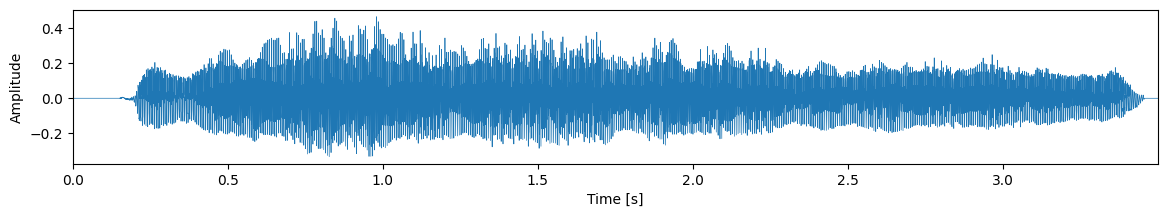

In [7]:
# Load sustained phonation recording from QPN dataset
audio_filename = "phonation.wav"
audio, sample_rate = torchaudio.load(audio_filename)

# Parameters for all figures in the document
plt.rcParams["figure.figsize"] = (14,2)
plt.rcParams['axes.xmargin'] = 0

# Downsample to reduce number of points on the plot
downsample_factor = 20
xs = torch.arange(len(audio[0,::downsample_factor])) / sample_rate * downsample_factor
plt.plot(xs, audio[0,::downsample_factor], linewidth=.5)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Intro

To understand how this speech analysis works, we'll step through the vocal feature computation functions, including:

* `speechbrain.processing.vocal_features.compute_autocorrelation_features`
* `speechbrain.processing.vocal_features.compute_periodic_features`
* `speechbrain.processing.vocal_features.compute_gne`

These different ways of approaching vocal features can give different indications of potential vocal pathology, which we will
explain as we go through the tutorial. We first just set up basic parameters that apply to all sections.

In [8]:
# Frequency of human speech is usually between 75-300 Hz
min_f0_Hz = 80
max_f0_Hz = 300

# A new window of 0.05 second length every 0.01 seconds
step_size = 0.01
window_size = 0.05

# Do some number manipulations
step_samples = int(step_size * sample_rate)
window_samples = int(window_size * sample_rate)
max_lag = int(sample_rate / min_f0_Hz)
min_lag = int(sample_rate / max_f0_Hz)

print("Samples between (the start of) one frame and the next:", step_samples)
print("Samples contained within each frame:", window_samples)
print("Number of samples in the maximum lag:", max_lag)
print("Number of samples in the minimum lag:", min_lag)

Samples between (the start of) one frame and the next: 441
Samples contained within each frame: 2205
Number of samples in the maximum lag: 551
Number of samples in the minimum lag: 147


Our sanity check for these values is that at least one complete period will be contained in the frame (for minimum Hz) and at most 8 for maximum Hz.

## Compute autocorrelation and related features

The first set of features, autocorrelation features, pick up on signs of pathology
as a result of breathy / noisy / irregular phonations. The cause is usually inadequate control over some aspect
of phonation, such as the vocal cords, causing the periods to become less regular.

Autocorrelation is the cross-correlation of a signal with itself at each lag from min_lag to max_lag.
The min lag and max lag correspond to the extremes of the human vocal range -- to reduce the chance of
false peaks at a frequency that can't possibly correspond with human vocalization.
For all periodic/harmonic signals (including phonations), there are peaks at regular lag intervals
corresponding to the period of the signal. The harmonicity is the ratio of the strongest peak against
the theoretical maximum which occurs when the lag is zero (as the signal perfectly lines up with itself at lag 0).

The harmonicity is a useful measure of pathology, as any irregularities will show up as a reduction in the
cross-correlation score of the signal against its time-shifted version.

For animations which may be helpful for understanding the concept of autocorrelation, see the following:
* [https://tahull.github.io/blog/2020/08/acf-animated](https://tahull.github.io/blog/2020/08/acf-animated)
* [https://github.com/chautruonglong/Fundamental-Frequency](https://github.com/chautruonglong/Fundamental-Frequency)

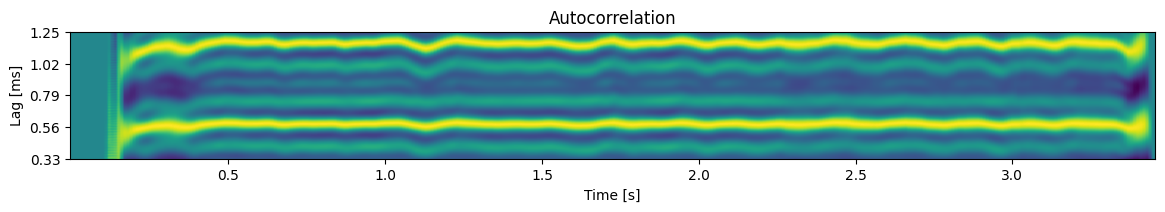

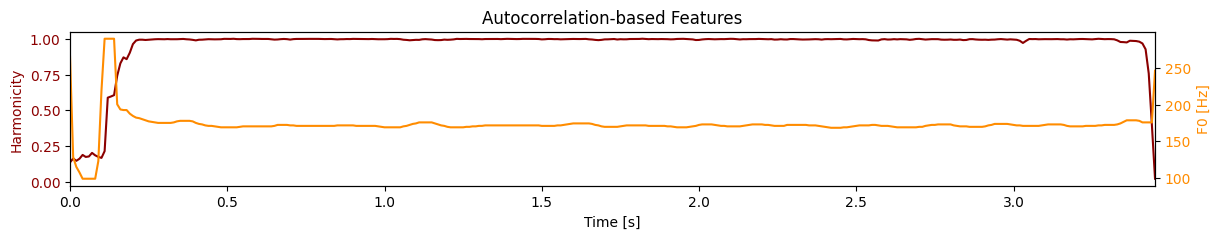

In [9]:
# Split into frames, and compute autocorrelation for each frame
frames = audio.unfold(-1, window_samples, step_samples)
autocorrelation = autocorrelate(frames)

# Use autocorrelation maxima to compute harmonicity (max) and lags (index) corresponding to estimated period
harmonicity, lags = autocorrelation[:, :, min_lag:max_lag].max(dim=-1)
lags = torch.nn.functional.pad(lags, pad=(3, 3))

# Take the median of 7 frames to avoid short octave jumps
best_lags, _ = lags.unfold(-1, 7, 1).median(dim=-1)

# Re-add the min_lag back in after previous step removed it
best_lags = best_lags + min_lag
estimated_f0 = sample_rate / best_lags

xs = torch.arange(len(harmonicity[0])) * step_size

# Show autocorrelation from min lag to max lag
plt.imshow(autocorrelation[0, :, min_lag:max_lag].transpose(0,1), aspect=0.1, origin="lower")
plt.title("Autocorrelation")
plt.ylabel("Lag [ms]")
plt.xlabel("Time [s]")
xticks = (torch.arange(1, 7) / 2 / step_size).int().tolist()
plt.xticks(xticks, xs[xticks].tolist())
yticks = torch.linspace(0, max_lag - min_lag, 5).int()
plt.yticks(yticks.tolist(), ((yticks + min_lag) / step_samples).numpy().round(decimals=2))
plt.show()

# Show autocorrelation-based features, harmonicity (usually represented in log scale as HNR) and f0
fig, ax1 = plt.subplots()
ax1.set_title("Autocorrelation-based Features")
ax1.set_ylabel("Harmonicity", color="darkred")
ax1.set_xlabel("Time [s]")
ax1.plot(xs, harmonicity[0], color="darkred")
ax1.tick_params(axis="y", labelcolor="darkred")
ax2 = ax1.twinx()
ax2.set_ylabel("F0 [Hz]", color="darkorange")
ax2.plot(xs, estimated_f0[0], color="darkorange")
ax2.tick_params(axis="y", labelcolor="darkorange")
plt.show()

To measure Harmonicity-to-Noise ratio (HNR), we need an estimate of noise, in addition to our earlier estimate of harmonicity.
According to the following publication, we can estimate the noise as just 1 - harmonicity, as any reductions in harmonicity are due to noise.

See "Harmonic to Noise Ratio Measurement - Selection of Window and Length"
By J. Fernandez, F. Teixeira, V. Guedes, A. Junior, and J. P. Teixeira

We have found, however, that the HNR is dominated by the noise term, so for
efficiency and simplicity, we just take -10 * log(noise) as the HNR value (in decibels).

The max value for HNR is 30 dB, enforced by clamping the noise to a minimum of 10^-3.

Average HNR: 23.8


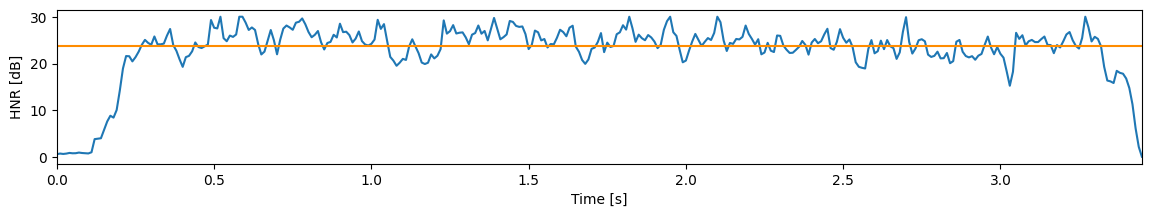

In [10]:
noise = torch.clamp(1 - harmonicity, min=10**-3)
hnr = -10 * torch.log10(noise)

plt.plot(xs, hnr[0])
plt.xlabel("Time [s]")
plt.ylabel("HNR [dB]")

# PRAAT uses harmonicity to determine voicing in this scenario
avg_hnr = hnr[harmonicity > 0.45].mean().numpy().round(decimals=1)
plt.axhline(y=avg_hnr, color="darkorange")
print("Average HNR:", avg_hnr)

## Computing period-based feats

Pathologies can also sometimes appear in the voice as irregularities in the period. Two features that have been used very commonly
in the speech diagnosis literature are *jitter* and *shimmer*.

You can find a good explanation here:

[https://speechprocessingbook.aalto.fi/Representations/Jitter_and_shimmer.html](https://speechprocessingbook.aalto.fi/Representations/Jitter_and_shimmer.html)

The most basic explanation is that jitter is a measure of the fluctuation in period *length* and shimmer is a measure of the
fluctuation in period *peak amplitude*.

In order to understand how this works, it is helpful to visualize a single frame. Let's use the frame #200, at 2.00 seconds into the recording.

We'll start by identifying the period peaks and masking everything not within 20% of the period peaks, so as to avoid jumping from the beginning to the middle of the period.

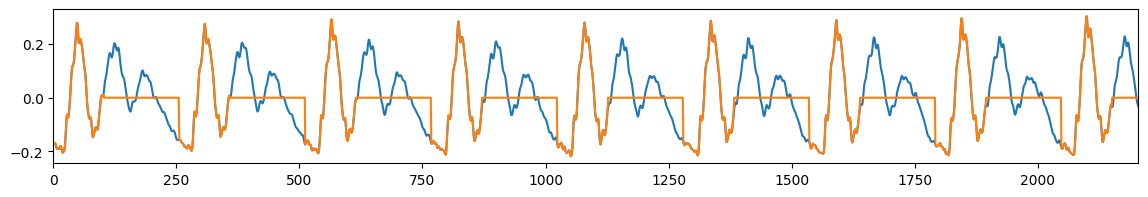

In [11]:
frame_i = 200
plt.plot(frames[0, frame_i])

# Prepare for masking
masked_frames = torch.clone(frames).detach()
mask_indices = torch.arange(frames.size(-1)).view(1, 1, -1)
mask_indices = mask_indices.expand(frames.shape)
periods = best_lags.unsqueeze(-1)
period_indices = mask_indices.remainder(periods)

# Mask everything not within about 20% (1/5) of a period peak
jitter_range = periods // 5
peak, lag = torch.max(masked_frames, dim=-1, keepdim=True)
mask = (
    (period_indices < lag.remainder(periods) - jitter_range)
    | (period_indices > lag.remainder(periods) + jitter_range)
)
masked_frames[mask] = 0


plt.plot(masked_frames[0, frame_i])
plt.show()

Next, we'll identify the four period peaks that we use for the computation of jitter and shimmer. We maintain a consistent number of period peaks regardless of the fundamental frequency, as this can affect the number of peaks that appear in the window. PRAAT uses 3 or 5 or 7 neighboring peaks to compute variations of jitter and shimmer. The number can be configured but it is important that even at the lowest frequency there is guaranteed to be 4 periods in the window.

tensor([ 437,  181, 1204,  693])


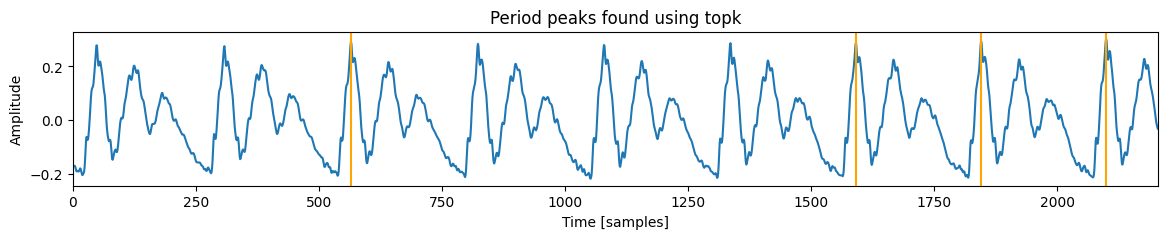

In [12]:
plt.plot(frames[0, frame_i])
peaks, lags = [], []

# Find neighboring peaks
peaks, lags = [], []
for i in range(4):
    peak, lag = torch.max(masked_frames, dim=-1, keepdim=True)
    mask = (
        (mask_indices > lag - periods // 2)
        & (mask_indices < lag + periods // 2)
    )
    masked_frames[mask] = 0
    peaks.append(peak.squeeze(-1))
    lags.append(lag.squeeze(-1))

peaks = torch.stack(peaks, dim=-1)
lags = torch.stack(lags, dim=-1)

for lag in lags[0, frame_i]:
    plt.axvline(lag, color="orange")

plt.title("Period peaks found using topk")
plt.xlabel("Time [samples]")
plt.ylabel("Amplitude")
print(lags[0, 230])

Jitter is the average variation in period length. We compare each period's length
against the period estimate across the whole window. The mean difference is the
jitter, after normalizing by the period to get a number from 0 to 1.

In [13]:
lags = lags.remainder(periods)
jitter_frames = (lags - lags.float().mean(dim=-1, keepdims=True)).abs()
jitter = jitter_frames.mean(dim=-1) / best_lags

print(lags[0, frame_i])
print(jitter_frames[0, frame_i] / best_lags[0, frame_i])
print(jitter[0, frame_i])

tensor([51, 53, 53, 55])
tensor([0.0078, 0.0000, 0.0000, 0.0078])
tensor(0.0039)


Average Jitter: 0.44%


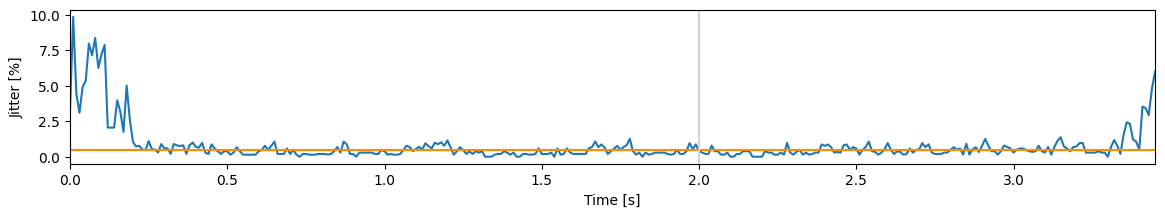

In [14]:
# PRAAT uses cutoff of jitter > 0.02 as un-voiced
plt.plot(xs, jitter[0] * 100)
plt.xlabel("Time [s]")
plt.ylabel("Jitter [%]")
plt.axhline(y = jitter[jitter < 0.02].mean() * 100, color="darkorange")
plt.axvline(x = frame_i / 100, color="lightgrey")
print("Average Jitter: {0:.2f}%".format(100 * jitter[jitter < 0.02].mean().numpy()))

Shimmer is the average variation in peak amplitude. We first compute the amplitude of each peak, then
we compute the difference of each peak from the average peak amplitude. The shimmer is just
the average difference normalized by the overall average amplitude to achieve a score from 0 to 1.

In [15]:
avg_amps = peaks.mean(dim=-1, keepdims=True)
amp_diff = (peaks - avg_amps).abs()
shimmer = amp_diff.mean(dim=-1) / avg_amps.squeeze(-1).clamp(min=1e-3)

print(amp_diff[0, frame_i] / avg_amps[0, frame_i])
print(shimmer[0, frame_i])

tensor([0.0294, 0.0015, 0.0098, 0.0210])
tensor(0.0154)


Average Shimmer: 2.21%


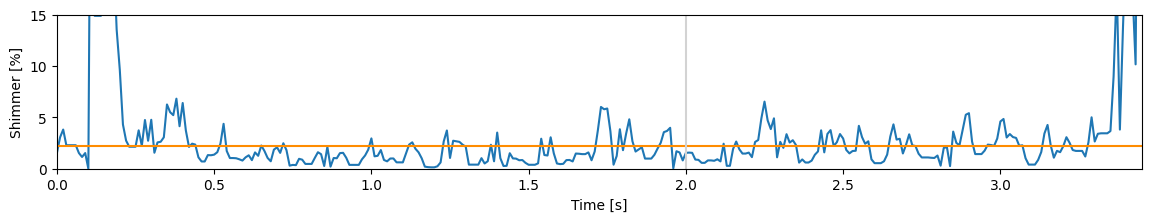

In [16]:
# PRAAT uses jitter to determine if its voiced
plt.plot(xs, shimmer[0] * 100)
plt.xlabel("Time [s]")
plt.ylabel("Shimmer [%]")
plt.ylim((0, 15))
plt.axhline(y = shimmer[jitter < 0.02].mean() * 100, color="darkorange")
plt.axvline(x = frame_i / 100, color="lightgrey")
print("Average Shimmer: {0:.2f}%".format(100 * shimmer[jitter < 0.02].mean().numpy()))

## Compute GNE step-by-step

An algorithm for GNE computation from the original paper:

"Glottal-to-Noise Excitation Ratio - a New Measure for Describing
Pathological Voices" by D. Michaelis, T. Oramss, and H. W. Strube.

This algorithm divides the signal into frequency bands, and compares
the correlation between the bands. High correlation indicates a
relatively low amount of noise in the signal, whereas lower correlation
could be a sign of pathology in the vocal signal.

Godino-Llorente et al. in "The Effectiveness of the Glottal to Noise
Excitation Ratio for the Screening of Voice Disorders" explore the
goodness of the bandwidth and frequency shift parameters, and write out
a clear description of how to compute the measure, used here.

In [17]:
# Step 1. Downsample to 10 kHz since voice energy is low above 5 kHz
new_sample_rate = 10000
downsampled_audio = torchaudio.functional.resample(audio, 44100, new_sample_rate)

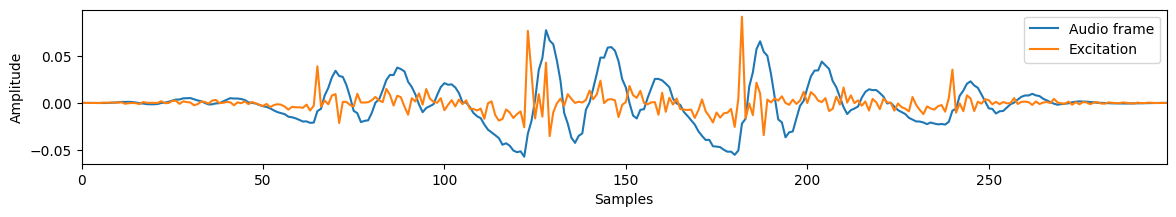

In [18]:
# Step 2. Inverse filter with 30-msec window, 10-msec hop and 13th order LPC
frame_size, hop_size, lpc_order = 300, 100, 13

# Solve for LPC coefficients
window = torch.hann_window(frame_size).view(1, 1, -1)
gne_frames = downsampled_audio.view(1, -1).unfold(-1, frame_size, hop_size) * window

autocorrelation = compute_cross_correlation(gne_frames, gne_frames, width=lpc_order)

# Collapse frame and batch into same dimension, for lfiltering
batch, frame_count, _ = autocorrelation.shape
autocorrelation = autocorrelation.view(batch * frame_count, -1)

# Construct Toeplitz matrices (one per frame)
# This is [[p0, p1, p2...], [p1, p0, p1...], [p2, p1, p0...] ...]
# Our sliding window should go from the end to the front, so flip
# The autocorrelation has an extra value on each end for our prediction values
R = autocorrelation[:, 1: -1].unfold(-1, lpc_order, 1).flip(dims=(1,))
r = autocorrelation[:, lpc_order + 1:]

# Solve for LPC coefficients, generate inverse filter with coeffs 1, -a_1, ...
lpc = torch.linalg.solve(R, r)
a_coeffs = torch.cat((torch.ones(lpc.size(0), 1), -lpc), dim=1)
b_coeffs = torch.zeros_like(a_coeffs)
b_coeffs[:, 0] = 1

# Perform filtering
excitation = torchaudio.functional.lfilter(gne_frames, b_coeffs, a_coeffs, clamp=False)
plt.plot(gne_frames[0, 200, :] * 0.3, label='Audio frame')
plt.plot(excitation[0, 200, :], label='Excitation')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

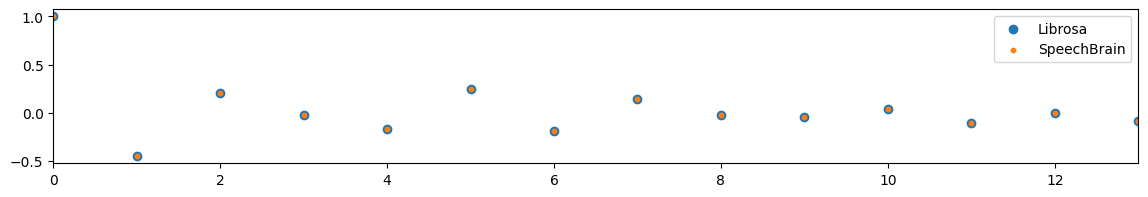

In [19]:
# Compare cf. librosa to check accuracy
import librosa

librosa_coeffs = librosa.lpc(gne_frames[0, 0].numpy(), order=lpc_order)
plt.scatter(torch.arange(lpc_order + 1), librosa_coeffs)
plt.scatter(torch.arange(lpc_order + 1), a_coeffs[0], s=10)
plt.legend(["Librosa", "SpeechBrain"])
plt.show()

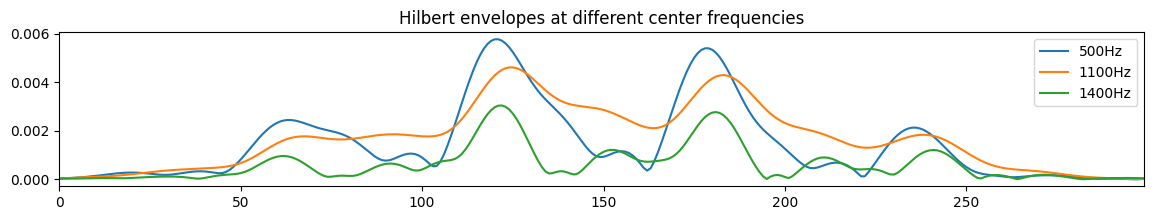

In [20]:
# Step 3. Compute Hilbert envelopes for each frequency bin
bandwidth = 1000
fshift = 300
min_freq, max_freq = bandwidth // 2, new_sample_rate // 2 - bandwidth // 2
center_freqs = range(min_freq, max_freq, fshift)
envelopes = {
    center_freq: compute_hilbert_envelopes(
        excitation, center_freq, bandwidth, new_sample_rate
    )
    for center_freq in center_freqs
}
plt.plot(envelopes[500][0, 200])
plt.plot(envelopes[1100][0, 200])
plt.plot(envelopes[1400][0, 200])
plt.legend(["500Hz", "1100Hz", "1400Hz"])
plt.title("Hilbert envelopes at different center frequencies")
plt.show()

In [21]:
# Step 4. Compute cross correlation between (non-neighboring) frequency bins
correlations = [
    compute_cross_correlation(envelopes[freq_i], envelopes[freq_j], width=3)
    for freq_i in center_freqs
    for freq_j in center_freqs
    if (freq_j - freq_i) > bandwidth // 2
]

# Step 5. The maximum cross-correlation is the GNE score
gne = torch.stack(correlations, dim=-1).amax(dim=(2, 3))
gne = -10 * torch.log10(1 - gne)

tensor(19.8546)


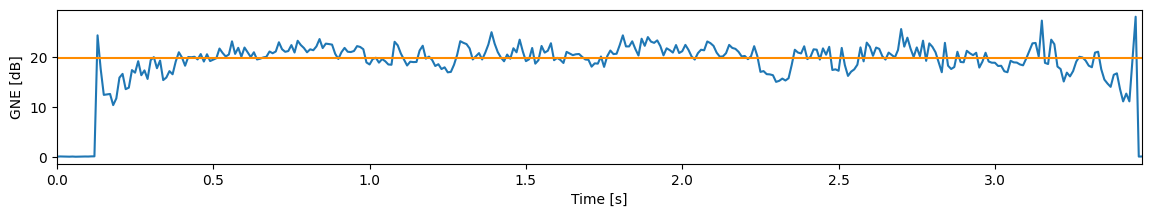

In [22]:
new_step_size = hop_size / new_sample_rate
gne_xs = torch.arange(len(gne[0])) * new_step_size
plt.plot(gne_xs, gne[0])
plt.xlabel("Time [s]")
plt.ylabel("GNE [dB]")
plt.axhline(gne[gne > 10].mean(), color="darkorange")
print(gne[gne > 10].mean())

## PRAAT-Parselmouth

The following is a side-by-side analysis with PRAAT to verify that our measures look accurate. To compute the PRAAT measures in Python, we use Parselmouth:

* [https://parselmouth.readthedocs.io/en/stable/](https://parselmouth.readthedocs.io/en/stable/)

In [23]:
%%capture
!pip install praat-parselmouth

In [24]:
import parselmouth
from parselmouth.praat import call
import numpy as np

# Bundle these to compute them again later
def compute_praat_features(audio_filename):
    f0min = 75
    f0max = 300
    
    sound = parselmouth.Sound(audio_filename)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    pitch = sound.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan

    jitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    shimmer = call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

    harmonicity = sound.to_harmonicity()

    return pitch.xs() - 0.02, pitch_values, jitter, shimmer, harmonicity


pitch_xs, pitch_values, praat_jitter, praat_shimmer, praat_harmonicity = compute_praat_features(audio_filename)

Estimated average frequency (SpeechBrain): 171.9 Hz
Estimated average frequency (PRAAT): 171.9 Hz


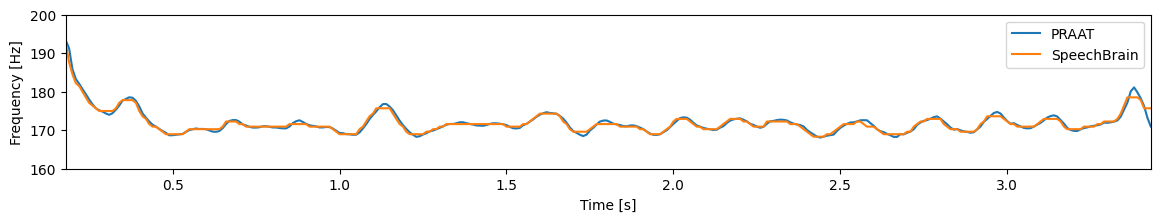

In [25]:
# Pitch comparison
plt.plot(pitch_xs, pitch_values)
voiced = np.isfinite(pitch_values[:-1])
plt.plot(xs[voiced], estimated_f0[0, voiced])
plt.ylim((160, 200))
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.legend(["PRAAT", "SpeechBrain"])

print("Estimated average frequency (SpeechBrain): {0:.1f} Hz".format(estimated_f0[0, voiced].mean().numpy()))
print("Estimated average frequency (PRAAT): {0:.1f} Hz".format(np.nanmean(pitch_values)))

In [26]:
print("Average Jitter (SpeechBrain): {0:.2f}%".format(100 * jitter[0, voiced].mean().numpy()))
print("Average Jitter (PRAAT): {0:.2f}%".format(100 * praat_jitter))

Average Jitter (SpeechBrain): 0.50%
Average Jitter (PRAAT): 0.35%


In [27]:
print("Average Shimmer (SpeechBrain): {0:.2f}%".format(100 * shimmer[0, voiced].mean().numpy()))
print("Average Shimmer (PRAAT): {0:.2f}%".format(100 * praat_shimmer))

Average Shimmer (SpeechBrain): 2.40%
Average Shimmer (PRAAT): 2.25%


Average HNR (SpeechBrain): 24.2%
Average HNR (PRAAT): 27.3%


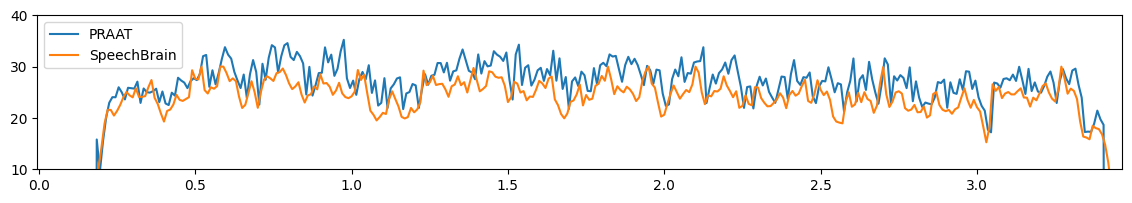

In [28]:
praat_hnr = call(praat_harmonicity, "Get mean", 0, 0)
plt.plot(praat_harmonicity.xs() - 0.02, praat_harmonicity.values.T)
plt.plot(xs[voiced], hnr[0, voiced])
plt.ylim((10, 40))
plt.legend(["PRAAT", "SpeechBrain"])
print("Average HNR (SpeechBrain): {0:.1f}%".format(hnr[0, voiced].mean().numpy()))
print("Average HNR (PRAAT): {0:.1f}%".format(praat_hnr))

## Comparison with OpenSMILE

Unlike PRAAT, we can do a frame-by-frame comparison of jitter and shimmer with OpenSMILE, which is helpful for further verification of our approach.

* [https://www.audeering.com/opensmile/](https://www.audeering.com/opensmile/)

In [29]:
%%capture
!pip install opensmile

In [30]:
import opensmile

opensmile_extractor = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

opensmile_feats = opensmile_extractor.process_file(audio_filename)
opensmile_feats.shape

(346, 25)

In [31]:
opensmile_feats.columns

Index(['Loudness_sma3', 'alphaRatio_sma3', 'hammarbergIndex_sma3',
       'slope0-500_sma3', 'slope500-1500_sma3', 'spectralFlux_sma3',
       'mfcc1_sma3', 'mfcc2_sma3', 'mfcc3_sma3', 'mfcc4_sma3',
       'F0semitoneFrom27.5Hz_sma3nz', 'jitterLocal_sma3nz',
       'shimmerLocaldB_sma3nz', 'HNRdBACF_sma3nz', 'logRelF0-H1-H2_sma3nz',
       'logRelF0-H1-A3_sma3nz', 'F1frequency_sma3nz', 'F1bandwidth_sma3nz',
       'F1amplitudeLogRelF0_sma3nz', 'F2frequency_sma3nz',
       'F2bandwidth_sma3nz', 'F2amplitudeLogRelF0_sma3nz',
       'F3frequency_sma3nz', 'F3bandwidth_sma3nz',
       'F3amplitudeLogRelF0_sma3nz'],
      dtype='object')

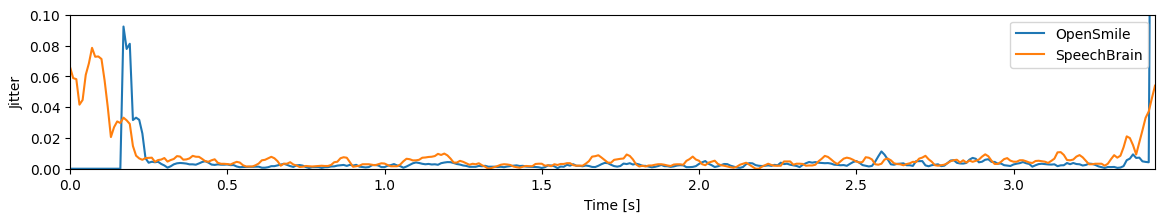

In [32]:
os_xs = opensmile_feats.index.get_level_values("start").total_seconds()
jitter_sma3 = torch.nn.functional.avg_pool1d(jitter, kernel_size=3, padding=1, stride=1, count_include_pad=False)
plt.plot(os_xs, opensmile_feats.jitterLocal_sma3nz)
plt.plot(xs, jitter_sma3[0])
plt.ylim((0, 0.1))
plt.xlabel("Time [s]")
plt.ylabel("Jitter")
plt.legend(["OpenSmile", "SpeechBrain"])

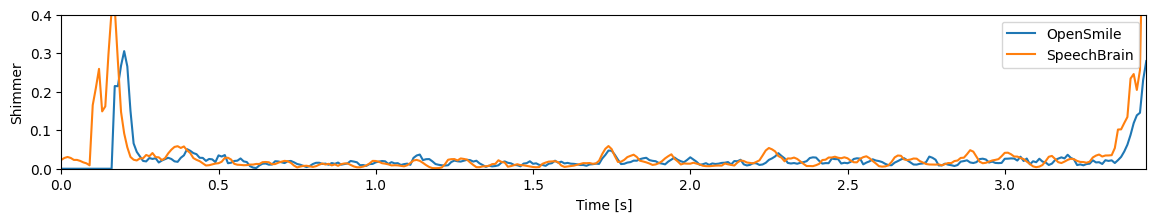

In [33]:
# From the name, it looks like shimmer should be in dB but the curve does not look it. Dividing by 10 is roughly the same.
plt.plot(os_xs, opensmile_feats.shimmerLocaldB_sma3nz / 10)
shimmer_sma3 = torch.nn.functional.avg_pool1d(shimmer, kernel_size=3, padding=1, stride=1, count_include_pad=False)
plt.plot(xs, shimmer_sma3[0])
plt.ylim((0, 0.4))
plt.xlabel("Time [s]")
plt.ylabel("Shimmer")
plt.legend(["OpenSmile", "SpeechBrain"])

12.219974517822266


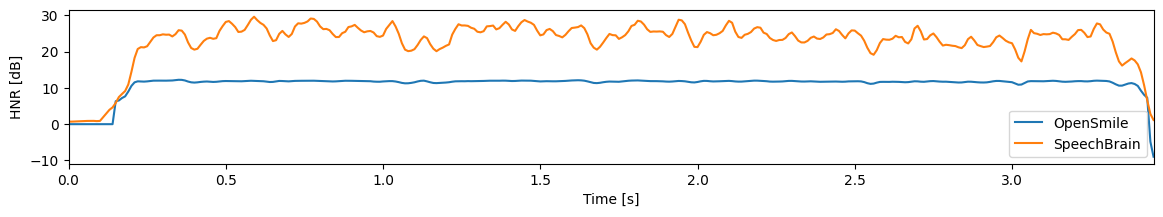

In [34]:
# Looks like there's a cap of ~12.5 dB for the openSmile features
plt.plot(os_xs, opensmile_feats.HNRdBACF_sma3nz)
hnr_sma3 = torch.nn.functional.avg_pool1d(hnr, kernel_size=3, padding=1, stride=1, count_include_pad=False)
plt.plot(xs, hnr_sma3[0])
plt.xlabel("Time [s]")
plt.ylabel("HNR [dB]")
plt.legend(["OpenSmile", "SpeechBrain"])
print(max(opensmile_feats.HNRdBACF_sma3nz))

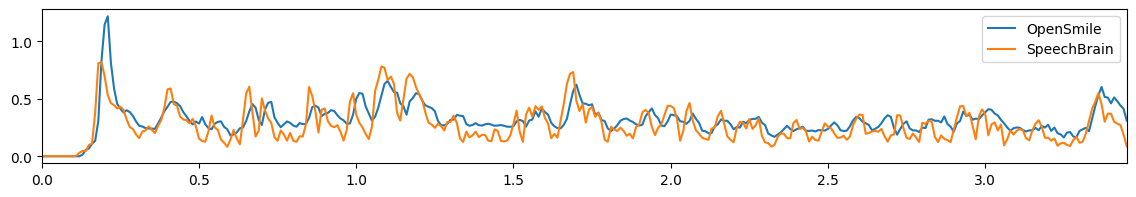

In [35]:
# Compute spectrum for remaining features
hann = torch.hann_window(window_samples).view(1, 1, -1)
spectrum = torch.abs(torch.fft.rfft(frames * hann))
spectral_feats = compute_spectral_features(spectrum)
# The last feature is flux
plt.plot(os_xs, opensmile_feats.spectralFlux_sma3)
plt.plot(xs, spectral_feats[0, :, -1])

plt.legend(["OpenSmile", "SpeechBrain"])

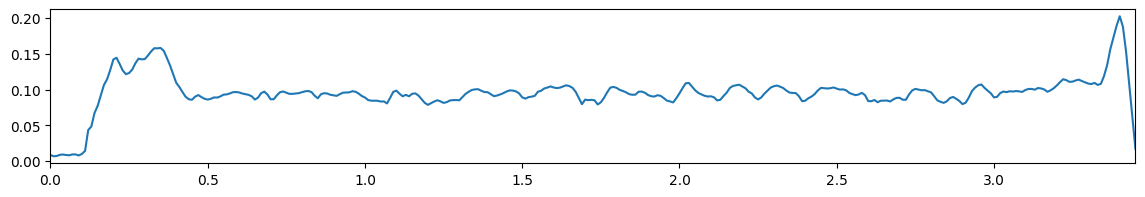

In [36]:
# Second-to-last is crest
plt.plot(xs, spectral_feats[0, :, -2])

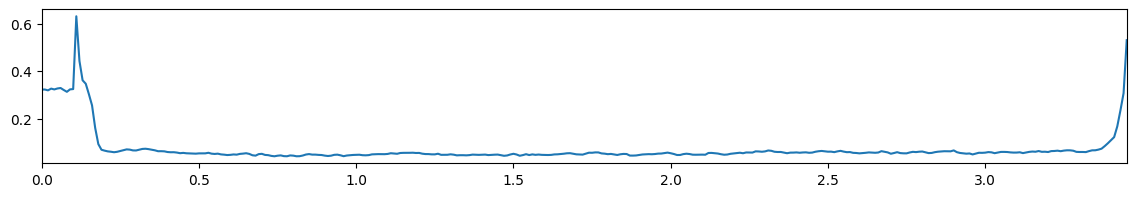

In [37]:
# Third to last is flatness
plt.plot(xs, spectral_feats[0, :, -3])

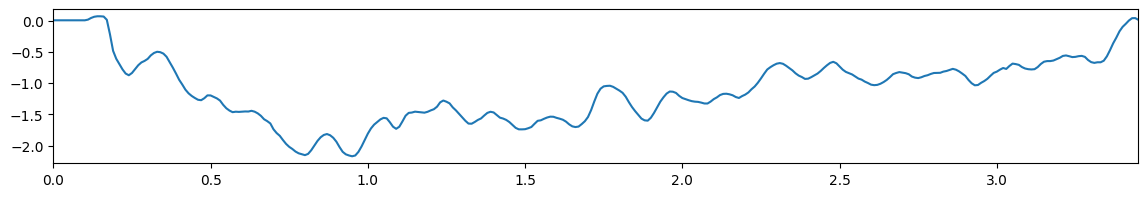

In [38]:
# Fourth to last is entropy
plt.plot(xs, spectral_feats[0, :, -4])

tensor(2.9860)
tensor(16.3373)


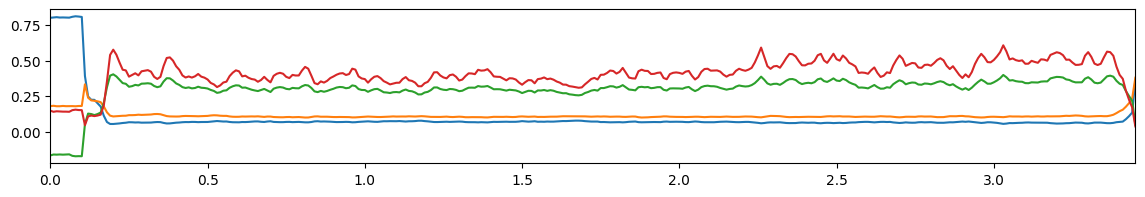

In [39]:
# These four are centroid, spread, skew, and kurtosis
plt.plot(xs, spectral_feats[0, :, 0])
plt.plot(xs, spectral_feats[0, :, 1])
plt.plot(xs, spectral_feats[0, :, 2] / 10)
plt.plot(xs, spectral_feats[0, :, 3] / 40)
print(spectral_feats[0, :, 2].mean())
print(spectral_feats[0, :, 3].mean())

## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```